# Off-the-shelf image classification with Swin Transformers on TF-Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sayakpaul/swin-transformers-tf/blob/main/notebooks/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sayakpaul/swin-transformers-tf/blob/main/notebooks/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://tfhub.dev/sayakpaul/collections/swin/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Setup

In [23]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt -O ilsvrc2012_wordnet_lemmas.txt

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [24]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2

## Select a [Swin](https://arxiv.org/abs/2103.14030) ImageNet-1k model

Find the entire collection [here](https://tfhub.dev/sayakpaul/collections/swin/1). For inferring with the ImageNet-22k models, please refer [here](https://tfhub.dev/google/bit/m-r50x1/imagenet21k_classification/1#usage).

In [25]:
model_name = "swin_tiny_patch4_window7_224" #@param ["swin_tiny_patch4_window7_224", "swin_small_patch4_window7_224", "swin_base_patch4_window7_224", "swin_base_patch4_window12_384", "swin_large_patch4_window7_224", "swin_large_patch4_window7_384", "swin_s3_tiny_224", "swin_s3_small_224", "swin_s3_base_224"]

model_handle_map ={
    "swin_tiny_patch4_window7_224": "https://tfhub.dev/sayakpaul/swin_tiny_patch4_window7_224/1",
    "swin_small_patch4_window7_224": "https://tfhub.dev/sayakpaul/swin_small_patch4_window7_224/1",
    "swin_base_patch4_window7_224": "https://tfhub.dev/sayakpaul/swin_base_patch4_window7_224/1",
    "swin_base_patch4_window12_384": "https://tfhub.dev/sayakpaul/swin_base_patch4_window12_384/1",
    "swin_large_patch4_window7_224": "https://tfhub.dev/sayakpaul/swin_large_patch4_window7_224/1",
    "swin_large_patch4_window7_384": "https://tfhub.dev/sayakpaul/swin_large_patch4_window7_384/1",
    "swin_s3_tiny_224": "https://tfhub.dev/sayakpaul/swin_s3_tiny_224/1",
    "swin_s3_small_224": "https://tfhub.dev/sayakpaul/swin_s3_small_224/1",
    "swin_s3_base_224": "https://tfhub.dev/sayakpaul/swin_s3_base_224/1",
}

input_resolution = int(model_name.split("_")[-1])
model_handle = model_handle_map[model_name]
print(f"Input resolution: {input_resolution} x {input_resolution} x 3.")
print(f"TF-Hub handle: {model_handle}.")

Input resolution: 224 x 224 x 3.
TF-Hub handle: https://tfhub.dev/sayakpaul/swin_tiny_patch4_window7_224/1.


## Image preprocessing utilities

In [26]:
crop_layer = keras.layers.CenterCrop(input_resolution, input_resolution)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)


def preprocess_image(image, size=input_resolution):
    image = np.array(image)
    image_resized = tf.expand_dims(image, 0)

    if size == 224:
        resize_size = int((256 / 224) * size)
        image_resized = tf.image.resize(image_resized, (resize_size, resize_size), method="bicubic")
        image_resized = crop_layer(image_resized)
    else:
        image_resized = tf.image.resize(image_resized, (size, size), method="bicubic")

    return norm_layer(image_resized).numpy()


def load_image_from_url(url):
    # Credit: Willi Gierke
    image = Image.open('data/cat.jpeg')
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image

## Load ImageNet-1k labels and a demo image

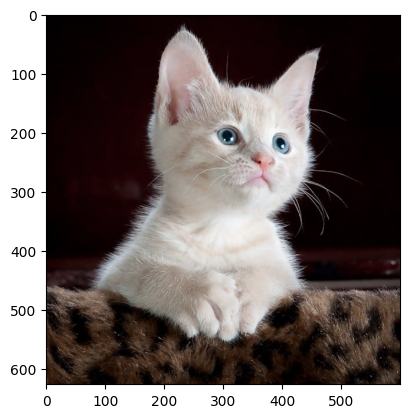

In [27]:
with open("ilsvrc2012_wordnet_lemmas.txt", "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://en.wikipedia.org/wiki/Elephant#/media/File:African_Bush_Elephant.jpg"
image, preprocessed_image = load_image_from_url(img_url)

plt.imshow(image)
plt.show()

## Run inference

In [28]:
def get_model(model_url: str) -> tf.keras.Model:
    inputs = tf.keras.Input((input_resolution, input_resolution, 3))
    hub_module = hub.KerasLayer(model_url)

    outputs = hub_module(inputs)

    return tf.keras.Model(inputs, outputs)

In [29]:
classification_model = get_model(model_handle)
predictions = classification_model.predict(preprocessed_image)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002BD581AA830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002BD581AA830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002BD581AA830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 2s 2s/step
Egyptian_cat


In [37]:
classification_model

## Obtain attention scores

In [30]:
swin_tiny_patch4_window7_224_tf = tf.keras.models.load_model(
    f"gs://tfhub-modules/sayakpaul/{model_name}/1/uncompressed"
)
all_attn_scores = swin_tiny_patch4_window7_224_tf.get_attention_scores(
    preprocessed_image
)
print(all_attn_scores.keys())

UnimplementedError: File system scheme 'gs' not implemented (file: 'gs://tfhub-modules/sayakpaul/swin_tiny_patch4_window7_224/1/uncompressed')

In [ ]:
# attn score dimensions:
# (batch_size, nb_attention_heads, seq_length, seq_length)
print(all_attn_scores["swin_stage_3"].keys()), print(all_attn_scores["swin_stage_3"]["swin_block_0"].shape)